In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import ER_multiclass as ER

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
# load data
X = np.loadtxt('../cardiotocography_X_cleaned.txt')
X.shape

(2126, 23)

In [4]:
y12 = np.loadtxt('../cardiotocography_y_cleaned.txt')
y12.shape

(2, 2126)

In [5]:
y = y12[1]  # fetal state

In [6]:
np.unique(y,return_counts=True)

(array([0., 1., 2.]), array([1655,  295,  176]))

In [7]:
t3 = y == 2.
X3 = X[t3]
y3 = y[t3]

t1 = y == 0.
X1 = X[t1]
y1 = y[t1]
t1 = np.random.choice(len(y1),len(y3),replace=False)
X1 = X1[t1]
y1 = y1[t1]

t2 = y == 1.
X2 = X[t2]
y2 = y[t2]
t2 = np.random.choice(len(y2),len(y3),replace=False)
X2 = X2[t2]
y2 = y2[t2]

X = np.vstack([X1,X2,X3])
y = np.hstack([y1,y2,y3])

In [8]:
X.shape

(528, 23)

In [9]:
y.shape

(528,)

In [10]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [11]:
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

In [12]:
def inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=100,regu=0.001)
        y_pred = ER.predict(X_test,h0,w)

    else:
        if method == 'logistic_regression':
            model = LogisticRegression(multi_class='multinomial',solver='saga')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)   
            
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    accuracy = accuracy_score(y_test,y_pred)                
                  
    return accuracy

In [13]:
def compare_inference(X,y,train_size):
    npred = 100
    accuracy = np.zeros((len(list_methods),npred))
    precision = np.zeros((len(list_methods),npred))
    recall = np.zeros((len(list_methods),npred))
    accuracy_train = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)

        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = inference(X_train,y_train,X_test,y_test,method)
            
    return accuracy.mean(axis=1),accuracy.std(axis=1)

In [14]:
list_train_size = [0.8,0.6,0.4,0.2]
list_methods=['logistic_regression','naive_bayes','random_forest','expectation_reflection']
acc = np.zeros((len(list_train_size),len(list_methods)))
acc_std = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:],acc_std[i,:] = compare_inference(X,y,train_size)
    print(train_size,acc[i,:])

0.8 [0.83103774 0.72556604 0.82490566 0.83735849]
0.6 [0.82179245 0.73113208 0.82575472 0.83283019]
0.4 [0.81245283 0.72773585 0.81641509 0.82283019]
0.2 [0.78377358 0.70783019 0.79735849 0.79462264]


In [15]:
df = pd.DataFrame(acc,columns = list_methods)
df.insert(0, "train_size",list_train_size, True)
df

,train_size,logistic_regression,naive_bayes,random_forest,expectation_reflection
0,0.8,0.831038,0.725566,0.824906,0.837358
1,0.6,0.821792,0.731132,0.825755,0.832830
2,0.4,0.812453,0.727736,0.816415,0.822830
3,0.2,0.783774,0.707830,0.797358,0.794623


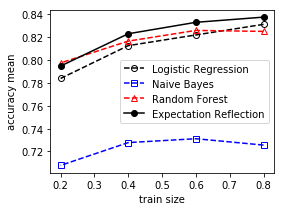

In [16]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc[:,-1],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy mean')
plt.legend()

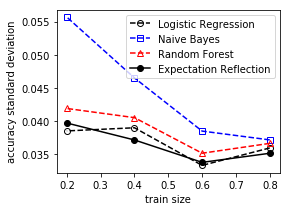

In [17]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc_std[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc_std[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc_std[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc_std[:,-1],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy standard deviation')
plt.legend()

In [19]:
np.savetxt('../cardiotocography_acc.txt',acc,fmt='%f')
np.savetxt('../cardiotocography_acc_std.txt',acc_std,fmt='%f')